# 画图：当客户端并不是从预训练参数开始的

In [1]:
import pandas as pd
import wandb
api = wandb.Api()

# Project is specified by <entity/project-name>
runs = api.runs("stupidtree/[EXP]SDRP_pre_ft")

summary_list, config_list, name_list = [], [], []
for run in runs:
    # .summary contains the output keys/values for metrics like accuracy.
    #  We call ._json_dict to omit large files
    summary_list.append(run.summary._json_dict)

    # .config contains the hyperparameters.
    #  We remove special values that start with _.
    config_list.append(
        {k: v for k,v in run.config.items()
          if not k.startswith('_')})

    # .name is the human-readable name of the run.
    name_list.append(run.name)

runs_df = pd.DataFrame({
    "summary": summary_list,
    "config": config_list,
    "name": name_list
    })


In [2]:
rouges = {}
rouges_bi = {}
rouges_tag = {}
ppl = {}
for summary, config, name in zip(summary_list, config_list, name_list):
    if not name.startswith('gpt2'):
        continue
    pre_ft_epoch = config['pre_ft_max_steps']
    if 'client0_DLG_raw_rgLf_avg' in summary:
        rouges_tag[pre_ft_epoch] = summary['client0_DLG_raw_rgLf_avg']
    else:
        rouges[pre_ft_epoch] = summary['client0_DRA_b2tr_rgLf_avg']
        rouges_bi[pre_ft_epoch] =  summary['client0_DLG_rgL_f_avg']
        ppl[pre_ft_epoch] = summary['client0_test-ppl']

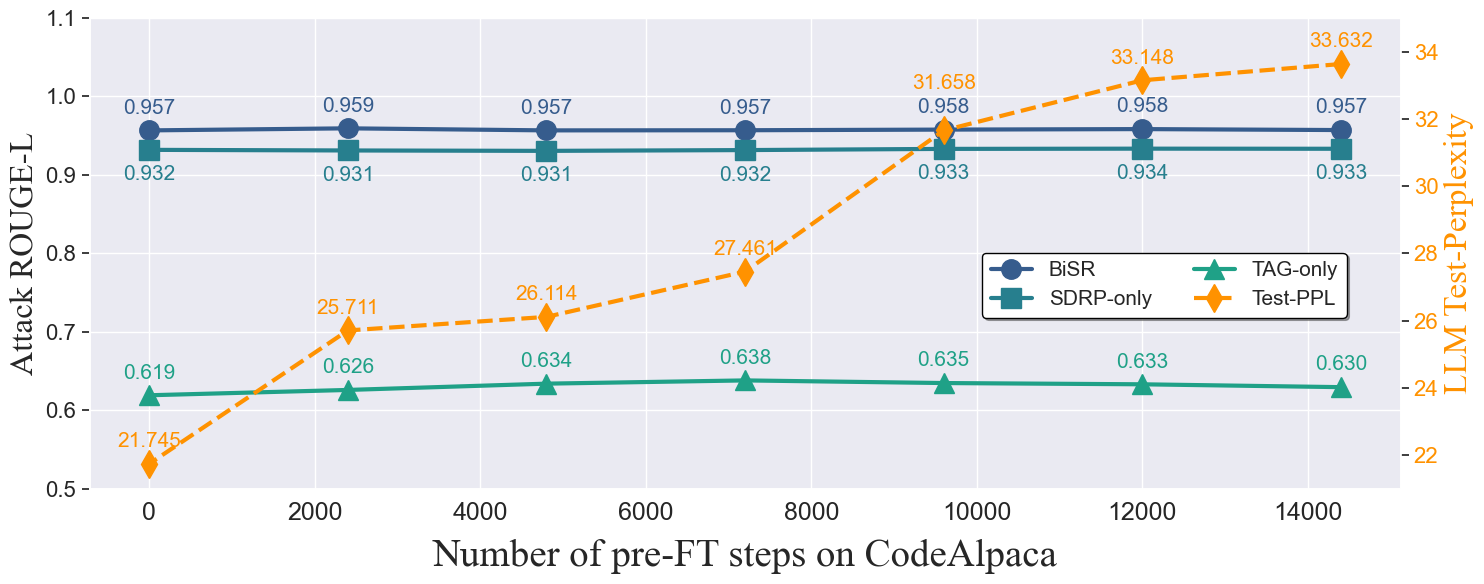

In [58]:

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

sns.set()
sns.set_style("darkgrid")
fig, ax1 = plt.subplots(figsize=(15, 6))
# plot rouge
atk_colors = sns.color_palette("viridis", 6)
atk_colors2 = sns.color_palette('coolwarm', 6)
atk_colors3 = sns.color_palette('cool', 6)
atk_colors4 = sns.color_palette('Spectral', 6)
color_ppl = sns.color_palette("autumn", 6)[3]
all_data = { 'Test-PPL':ppl,'BiSR': rouges_bi, 'SDRP-only': rouges, 'TAG-only': rouges_tag}
colors = {'BiSR': atk_colors[1], 'SDRP-only': atk_colors[2], 'TAG-only': atk_colors[3], 'Test-PPL':color_ppl}
markers = {'BiSR': 'o', 'SDRP-only': 's', 'TAG-only': '^','Test-PPL':'d'}

ax1.set_ylabel('Attack ROUGE-L', fontsize=24,fontname="Times New Roman")
ax1.tick_params(axis='x', labelsize=18)
ax1.tick_params(axis='y', labelsize=16)
# the font suitable for thesis
ax1.set_xlabel('Number of pre-FT steps on CodeAlpaca', fontsize=28, fontname="Times New Roman", labelpad=10)
ax1.set_ylim(0.5, 1.1)
ax2 = ax1.twinx()
ax2.set_ylabel('LLM Test-Perplexity', fontsize=24, fontname="Times New Roman", color=color_ppl)
ax2.tick_params(axis='y', labelcolor=color_ppl, labelsize=16)
ax2.set_ylim(21, 35)
for name, data in all_data.items():
    axis = ax1
    linestyle='-'
    if name =='Test-PPL':
        axis = ax2
        linestyle = '--'
    axis.plot(data.keys(), data.values(), color=colors[name], marker=markers[name], markersize=14, label=name, linestyle=linestyle, linewidth=3)

    for i, (ep, rg) in enumerate(data.items()):
        ofst = 12
        if name == 'SDRP-only':
            ofst = -22
        if name =='Test-PPL' and ep == 9600:
            ofst = 30
        axis.annotate(f'{rg:.3f}', (ep, rg), textcoords="offset points",
                     xytext=(0, ofst),
                     ha='center', fontsize=15, color=colors[name])


# the legend with rounded corner and white background
fig.legend(loc='lower right', bbox_to_anchor=(0.91, 0.44), ncol=2, fontsize=15, frameon=True, fancybox=True, shadow=True, framealpha=1, edgecolor='black',facecolor='white')

ax2.yaxis.grid(False)


# save the figure
plt.tight_layout()
plt.savefig('/root/autodl-tmp/sfl/exp_data/pre_ft.pdf')